In [1]:
! mkdir ~/.kaggle

In [2]:
! cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 98% 771M/788M [00:03<00:00, 242MB/s]
100% 788M/788M [00:04<00:00, 206MB/s]


In [5]:
!unzip /content/microsoft-catsvsdogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

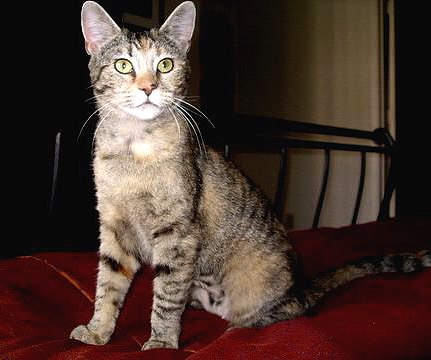

In [8]:
img=load_img('/content/PetImages/Cat/10000.jpg')
img

In [9]:
import tqdm

In [10]:
import os
input_path=[]
label=[]
for i in os.listdir('PetImages'):
    for path in os.listdir('PetImages/'+i):
      if i=='Cat':
        label.append(0)
      else:
        label.append(1)
      input_path.append(os.path.join('PetImages',i,path))
print(input_path[0],label[0])

PetImages/Dog/9694.jpg 1


In [11]:
len(input_path)

25002

In [12]:
df=pd.DataFrame()
df['Images']=input_path
df['label']=label
# df.sample(frac=1).reset_index(drop=True)
df.head()

,Images,label
0,PetImages/Dog/9694.jpg,1
1,PetImages/Dog/2354.jpg,1
2,PetImages/Dog/5427.jpg,1
3,PetImages/Dog/8766.jpg,1
4,PetImages/Dog/6034.jpg,1


In [15]:
for i in df['Images']:
  if '.jpg' not in i:
    df=df[df['Images']!=i]
    print('ok')

ok
ok


In [18]:
import PIL
l=[]
for image in df['Images']:
  try:
    img=PIL.Image.open(image)
  except:
    l.append(image)
l


['PetImages/Dog/11702.jpg', 'PetImages/Cat/666.jpg']

In [19]:
for i in l:
  df=df[df['Images']!=i]
  print(i)

PetImages/Dog/11702.jpg
PetImages/Cat/666.jpg


In [20]:
df.shape

(24998, 2)

In [16]:
import random


In [17]:
plt.figure(figsize=(25,25))
temp=df[df['label']==1]['Images']
start=random.randint(0,len(temp))
files=temp[start:start+25]
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [22]:
plt.figure(figsize=(25,25))
temp=df[df['label']==0]['Images']
start=random.randint(0,len(temp))
files=temp[start:start+25]
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

<Axes: ylabel='count'>

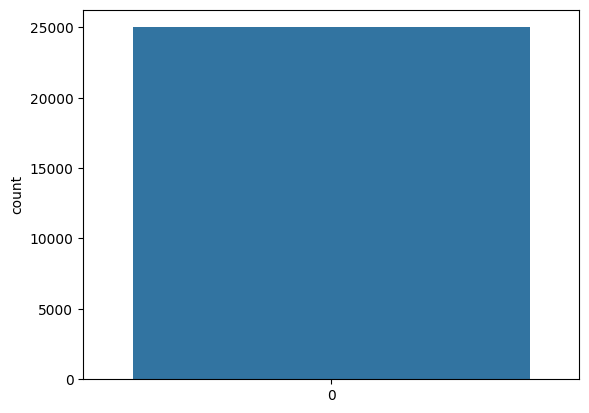

In [29]:
import seaborn as sns
sns.countplot(df['label'])

In [25]:
df['label'].value_counts()

0    12501
1    12501
Name: label, dtype: int64

Data Generator

In [21]:
df['label']=df['label'].astype('str')
df.head()

,Images,label
0,PetImages/Dog/9694.jpg,1
1,PetImages/Dog/2354.jpg,1
2,PetImages/Dog/5427.jpg,1
3,PetImages/Dog/8766.jpg,1
4,PetImages/Dog/6034.jpg,1


In [22]:
#input_split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,test_size=0.2,random_state=42)

In [23]:
train_generator=ImageDataGenerator(
    rescale=1./255,   #normalization of data
    rotation_range=40,   #augmentation of data
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
train_iterator=train_generator.flow_from_dataframe(train,x_col='Images',y_col='label',target_size=(128,128),batch_size=512,class_mode='binary')

Found 19998 validated image filenames belonging to 2 classes.


In [24]:
val_generator=ImageDataGenerator(rescale=1./255)

val_iterator=val_generator.flow_from_dataframe(test,x_col='Images',y_col='label',target_size=(128,128),batch_size=512,class_mode='binary')

Found 5000 validated image filenames belonging to 2 classes.


Model Creation


In [25]:
from keras import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense

model=Sequential([
    Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D((2,2)),

    Flatten(),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [28]:
history=model.fit(train_iterator,epochs=10,validation_data=val_iterator)

Epoch 1/10
40/40 [==============================] - 153s 4s/step - loss: 0.6668 - accuracy: 0.5833 - val_loss: 0.6205 - val_accuracy: 0.6406
Epoch 2/10
40/40 [==============================] - 150s 4s/step - loss: 0.5992 - accuracy: 0.6757 - val_loss: 0.5608 - val_accuracy: 0.7118
Epoch 3/10
40/40 [==============================] - 147s 4s/step - loss: 0.5561 - accuracy: 0.7153 - val_loss: 0.5498 - val_accuracy: 0.7192
Epoch 4/10
40/40 [==============================] - 147s 4s/step - loss: 0.5474 - accuracy: 0.7190 - val_loss: 0.5230 - val_accuracy: 0.7396
Epoch 5/10
40/40 [==============================] - 149s 4s/step - loss: 0.5160 - accuracy: 0.7438 - val_loss: 0.4958 - val_accuracy: 0.7568
Epoch 6/10
40/40 [==============================] - 147s 4s/step - loss: 0.5125 - accuracy: 0.7431 - val_loss: 0.5155 - val_accuracy: 0.7510
Epoch 7/10
40/40 [==============================] - 148s 4s/step - loss: 0.4966 - accuracy: 0.7580 - val_loss: 0.4842 - val_accuracy: 0.7686
Epoch 8/10
40

In [32]:
import pickle
with open('DogVsCatModel.pkl','wb') as f:
  pickle.dump(history,f)

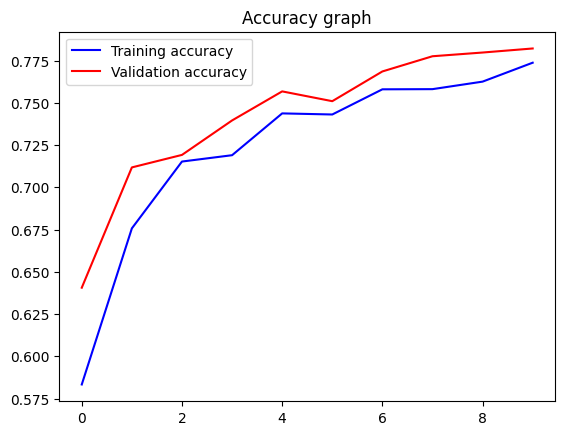

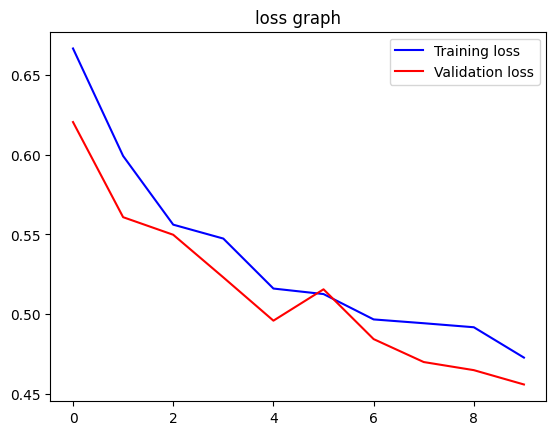

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()


loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('loss graph')
plt.legend()
plt.show()

(500, 403, 3)


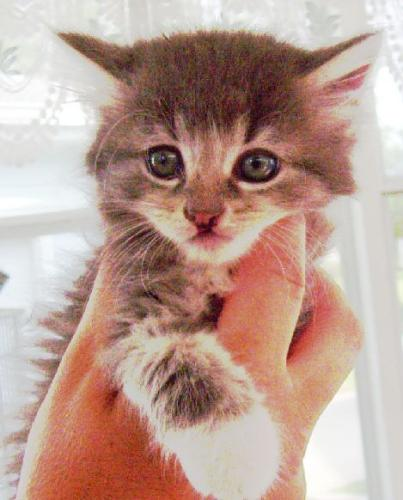

In [80]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/PetImages/Cat/100.jpg')
print(img.shape)
cv2_imshow(img)

In [79]:
img=cv2.imread('/content/PetImages/Cat/100.jpg')
cat=['Cat','Dog']
img=cv2.resize(img,(128,128))
img=img.reshape((1,128,128,3))
cat[int(model.predict(img)[0][0])]

1/1 [==============================] - 0s 20ms/step


'Cat'